<a href="https://colab.research.google.com/github/kronze1996/Product-Recommendation-Engine/blob/main/Kartikey_Sharma_Product_Recommendation_Engine_Capstone_Project_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Build a recommender engine that reviews customer ratings and purchase history to recommend items and improve sales. </u></b>

### Amazon.com is one of the largest electronic commerce and cloud computing companies.

### Just a few Amazon related facts:

### They lost $4.8 million in August 2013, when their website went down for 40 mins. They hold the patent on 1-Click buying, and licenses it to Apple. Their Phoenix fulfilment centre is a massive 1.2 million square feet. Amazon relies heavily on a Recommendation engine that reviews customer ratings and purchase history to recommend items and improve sales.


### This is a dataset related to over 2 Million customer reviews and ratings of Beauty related products sold on their website.

### It contains

* ### the unique UserId (Customer Identification),
* ### the product ASIN (Amazon's unique product identification code for each product),
* ### Ratings (ranging from 1-5 based on customer satisfaction) and
* ### the Timestamp of the rating (in UNIX time)

### This dataset contains product reviews and metadata from Amazon, including 142.8 million reviews spanning May 1996 - July 2014.

### This dataset includes reviews (ratings, text, helpfulness votes), product metadata (descriptions, category information, price, brand, and image features), and links (also viewed/also bought graphs).


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [106]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame 

from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from scipy.spatial.distance import cosine
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import re
import string
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import mean_squared_error

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
path = "/content/drive/MyDrive/AlmaBetter/Cohort Aravali/Module 4/Week 4/ratings_Beauty.csv"
df = pd.read_csv(path)
review_df = pd.read_json('/content/drive/MyDrive/AlmaBetter/Cohort Aravali/Module 4/Week 4/reviews_Beauty_5 (1).json.gz',lines = True)

#Exploratory Data Analysis

In [7]:
df.drop_duplicates(inplace=True)
df.shape

(2023070, 4)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2023070 entries, 0 to 2023069
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   UserId     object 
 1   ProductId  object 
 2   Rating     float64
 3   Timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 77.2+ MB


In [11]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198502 entries, 0 to 198501
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   reviewerID      198502 non-null  object
 1   asin            198502 non-null  object
 2   reviewerName    197116 non-null  object
 3   helpful         198502 non-null  object
 4   reviewText      198502 non-null  object
 5   overall         198502 non-null  int64 
 6   summary         198502 non-null  object
 7   unixReviewTime  198502 non-null  int64 
 8   reviewTime      198502 non-null  object
dtypes: int64(2), object(7)
memory usage: 13.6+ MB


In [12]:
df.head(20)

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200
5,AKJHHD5VEH7VG,0762451459,5.0,1404518400
6,A1BG8QW55XHN6U,1304139212,5.0,1371945600
7,A22VW0P4VZHDE3,1304139220,5.0,1373068800
8,A3V3RE4132GKRO,130414089X,5.0,1401840000
9,A327B0I7CYTEJC,130414643X,4.0,1389052800


In [13]:
df['ProductId'].value_counts()

B001MA0QY2    7533
B0009V1YR8    2869
B0043OYFKU    2477
B0000YUXI0    2143
B003V265QW    2088
              ... 
B001T0HH92       1
B002LE125A       1
B0033U11H0       1
B00DDU7EFI       1
B000J47AH8       1
Name: ProductId, Length: 249274, dtype: int64

In [14]:
review_df.head(20)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1YJEY40YUW4SE,7806397051,Andrea,"[3, 4]",Very oily and creamy. Not at all what I expect...,1,Don't waste your money,1391040000,"01 30, 2014"
1,A60XNB876KYML,7806397051,Jessica H.,"[1, 1]",This palette was a decent price and I was look...,3,OK Palette!,1397779200,"04 18, 2014"
2,A3G6XNM240RMWA,7806397051,Karen,"[0, 1]",The texture of this concealer pallet is fantas...,4,great quality,1378425600,"09 6, 2013"
3,A1PQFP6SAJ6D80,7806397051,Norah,"[2, 2]",I really can't tell what exactly this thing is...,2,Do not work on my face,1386460800,"12 8, 2013"
4,A38FVHZTNQ271F,7806397051,Nova Amor,"[0, 0]","It was a little smaller than I expected, but t...",3,It's okay.,1382140800,"10 19, 2013"
5,A3BTN14HIZET6Z,7806397051,"S. M. Randall ""WildHorseWoman""","[1, 2]","I was very happy to get this palette, now I wi...",5,Very nice palette!,1365984000,"04 15, 2013"
6,A1Z59RFKN0M5QL,7806397051,"tasha ""luvely12b""","[1, 3]",PLEASE DONT DO IT! this just rachett the palet...,1,smh!!!,1376611200,"08 16, 2013"
7,AWUO9P6PL1SY8,7806397051,TreMagnifique,"[0, 1]","Chalky,Not Pigmented,Wears off easily,Not a Co...",2,"Chalky, Not Pigmented, Wears off easily, Not a...",1378252800,"09 4, 2013"
8,A3LMILRM9OC3SA,9759091062,NaN,"[0, 0]",Did nothing for me. Stings when I put it on. I...,2,"no Lightening, no Brightening,......NOTHING",1405209600,"07 13, 2014"
9,A30IP88QK3YUIO,9759091062,Amina Bint Ibraheem,"[0, 0]",I bought this product to get rid of the dark s...,3,Its alright,1388102400,"12 27, 2013"


Exploring the data sets

In [15]:
df[df['UserId']=='A1YJEY40YUW4SE']

,UserId,ProductId,Rating,Timestamp
340,A1YJEY40YUW4SE,7806397051,1.0,1391040000
440062,A1YJEY40YUW4SE,B000V6BCSW,2.0,1391040000
807482,A1YJEY40YUW4SE,B0020YLEYK,5.0,1328140800
942164,A1YJEY40YUW4SE,B002WLWX82,1.0,1391040000
1177542,A1YJEY40YUW4SE,B004756YJA,5.0,1318896000
1337973,A1YJEY40YUW4SE,B004ZT0SSG,5.0,1318896000
1538217,A1YJEY40YUW4SE,B006XL55FK,5.0,1391040000
1982381,A1YJEY40YUW4SE,B00GZTXTZI,4.0,1391040000


In [16]:
df['Rating'].value_counts()

5.0    1248721
4.0     307740
1.0     183784
3.0     169791
2.0     113034
Name: Rating, dtype: int64

In [17]:
df['UserId'].value_counts()

A3KEZLJ59C1JVH    389
A281NPSIMI1C2R    336
A3M174IC0VXOS2    326
A2V5R832QCSOMX    278
A3LJLRIZL38GG3    276
                 ... 
ALE3O0431WGQG       1
A1X2W37T9RSXJF      1
A1P2QJ23SZ3SVM      1
A16FZGUK1T2W98      1
A28MJ51GOXSEDB      1
Name: UserId, Length: 1210271, dtype: int64

In [105]:
review_df

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1YJEY40YUW4SE,7806397051,Andrea,"[3, 4]",Very oily and creamy. Not at all what I expect...,1,Don't waste your money,1391040000,"01 30, 2014"
1,A60XNB876KYML,7806397051,Jessica H.,"[1, 1]",This palette was a decent price and I was look...,3,OK Palette!,1397779200,"04 18, 2014"
2,A3G6XNM240RMWA,7806397051,Karen,"[0, 1]",The texture of this concealer pallet is fantas...,4,great quality,1378425600,"09 6, 2013"
3,A1PQFP6SAJ6D80,7806397051,Norah,"[2, 2]",I really can't tell what exactly this thing is...,2,Do not work on my face,1386460800,"12 8, 2013"
4,A38FVHZTNQ271F,7806397051,Nova Amor,"[0, 0]","It was a little smaller than I expected, but t...",3,It's okay.,1382140800,"10 19, 2013"
...,...,...,...,...,...,...,...,...,...
198497,A2BLFCOPSMBOZ9,B00LLPT4HI,Dave Edmiston,"[0, 0]",Just a little dab of this shea butter should b...,5,A little dab...,1405468800,"07 16, 2014"
198498,A1UQBFCERIP7VJ,B00LLPT4HI,Margaret Picky,"[0, 0]",This shea butter is completely raw and unrefin...,5,Pure organic raw shea butter,1405296000,"07 14, 2014"
198499,A35Q0RBM3YNQNF,B00LLPT4HI,M. Hill,"[0, 0]",The skin is the body's largest organ and it ab...,5,One Pound Organic Grade A Unrefined Shea Butter,1405468800,"07 16, 2014"
198500,A3LGT6UZL99IW1,B00LLPT4HI,"Richard C. Drew ""Anaal Nathra/Uthe vas Bethod...","[0, 0]",I have very dry elbows and knees. I have a to...,5,This stuff is amazing!,1405382400,"07 15, 2014"


In [ ]:
fig, axes = plt.subplots(ncols=2,figsize=(13,8))
Day_df=review_df['SEX'].value_counts().reset_index()
plt.figure(figsize=(13,8))
review_df['SEX'].value_counts().plot(kind="pie",ax = axes[0],subplots=True)
sns.barplot(x='index',y='SEX',data=Day_df,ax = axes[1])

In [ ]:
review_df['asin']

In [121]:
# Day_df=review_df['overall'].value_counts().reset_index()
x=list(dfNew['asin'])
y=list(dfNew['overallScore'])
plt.plot(x,y)
plt.show()

KeyboardInterrupt: ignored

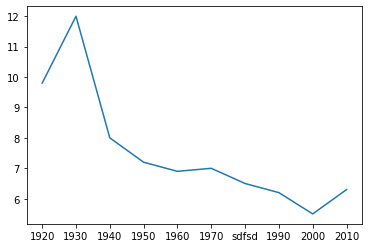

In [124]:
Year = [1920,1930,1940,1950,1960,1970,'sdfsd',1990,2000,2010]
Unemployment_Rate = [9.8,12,8,7.2,6.9,7,6.5,6.2,5.5,6.3]
plt.plot(Year,Unemployment_Rate)
plt.show()

In [125]:
y=list(dfNew['asin'])
type(y)

list

#Content Based Filtering

## <u><b> Content-Based Filtering </b></u>

### This method uses only information about the description and attributes of the items users has previously consumed to model user's preferences. In other words, these algorithms try to recommend items that are similar to those that a user liked in the past (or is examining in the present). In particular, various candidate items are compared with items previously rated by the user and the best-matching items are recommended. 


Recommender systems have a problem known as user cold-start, in which it is hard to provide personalized recommendations for users with none or a very few number of consumed items, due to the lack of information to model their preferences.  

For this reason, we are keeping in the dataset only users with at least 5 interactions.

In [ ]:
users_interactions_count_df = df.groupby(['UserId', 'ProductId']).size().groupby('UserId').size()
print('# of users: %d' % len(users_interactions_count_df))

users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['UserId']]
print('# of users with at least 5 interactions: %d' % len(users_with_enough_interactions_df))

# of users: 1210271
# of users with at least 5 interactions: 52374


In [ ]:
users_with_enough_interactions_df.value_counts()

UserId               
AZZZLM1E5JJ8C            1
A29FFXE1ZJWMDB           1
A29GNM310NIEGI           1
A29GF42C0YFQOK           1
A29GES4X1DL5JV           1
                        ..
A3III07Y9VJI8Q           1
A3IIGCFLKVFW8M           1
A3IIG6WN78DIOQ           1
A3IIDZ9XUDM7RP           1
A00414041RD0BXM6WK0GX    1
Length: 52374, dtype: int64

Checking for user with 1 interaction

In [ ]:
users_with_enough_interactions_df[users_with_enough_interactions_df['UserId']=='A27TKCMDYFCFOY']

,UserId


In [ ]:
print('# of interactions: %d' % len(df))
interactions_from_selected_users_df = df.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'UserId',
               right_on = 'UserId')
print('# of interactions from users with at least 5 interactions: %d' % len(interactions_from_selected_users_df))

# of interactions: 2023070
# of interactions from users with at least 5 interactions: 469771


In [ ]:
interactions_from_selected_users_df.head(10)

,UserId,ProductId,Rating,Timestamp
0,A00414041RD0BXM6WK0GX,B007IY97U0,3.0,1405296000
1,A00414041RD0BXM6WK0GX,B00870XLDS,2.0,1405296000
2,A00414041RD0BXM6WK0GX,B008MIRO88,1.0,1405296000
3,A00414041RD0BXM6WK0GX,B00BQYYMN0,3.0,1405296000
4,A00414041RD0BXM6WK0GX,B00GRTQBTM,5.0,1405296000
5,A00414041RD0BXM6WK0GX,B00HFP4JZU,5.0,1405296000
6,A00414041RD0BXM6WK0GX,B00JM8Z52O,4.0,1405296000
7,A00473363TJ8YSZ3YAGG9,B000052YQU,2.0,1402790400
8,A00473363TJ8YSZ3YAGG9,B00016XA0K,3.0,1399593600
9,A00473363TJ8YSZ3YAGG9,B000FABN7E,5.0,1357430400


In [ ]:
interactions_from_selected_users_df[interactions_from_selected_users_df['UserId']=='A27TKCMDYFCFOY']

,UserId,ProductId,Rating,Timestamp


#Collaborative Filtering

## <u><b> Collaborative Filtering </b></u> 

This method makes automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating). The underlying assumption of the collaborative filtering approach is that if a person A has the same opinion as a person B on a set of items, A is more likely to have B's opinion for a given item than that of a randomly chosen person.   



In [19]:
review_df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1YJEY40YUW4SE,7806397051,Andrea,"[3, 4]",Very oily and creamy. Not at all what I expect...,1,Don't waste your money,1391040000,"01 30, 2014"
1,A60XNB876KYML,7806397051,Jessica H.,"[1, 1]",This palette was a decent price and I was look...,3,OK Palette!,1397779200,"04 18, 2014"
2,A3G6XNM240RMWA,7806397051,Karen,"[0, 1]",The texture of this concealer pallet is fantas...,4,great quality,1378425600,"09 6, 2013"
3,A1PQFP6SAJ6D80,7806397051,Norah,"[2, 2]",I really can't tell what exactly this thing is...,2,Do not work on my face,1386460800,"12 8, 2013"
4,A38FVHZTNQ271F,7806397051,Nova Amor,"[0, 0]","It was a little smaller than I expected, but t...",3,It's okay.,1382140800,"10 19, 2013"


In [20]:
review_df.shape

(198502, 9)

In [71]:
count = review_df.groupby("asin", as_index=False).count()
count

,asin,reviewerID,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,7806397051,8,8,8,8,8,8,8,8
1,9759091062,11,10,11,11,11,11,11,11
2,9788072216,5,5,5,5,5,5,5,5
3,9790790961,6,6,6,6,6,6,6,6
4,9790794231,5,5,5,5,5,5,5,5
...,...,...,...,...,...,...,...,...,...
12096,B00L5KTZ0K,15,15,15,15,15,15,15,15
12097,B00L6Q3BH6,5,5,5,5,5,5,5,5
12098,B00LCEROA2,9,9,9,9,9,9,9,9
12099,B00LG63DOM,10,10,10,10,10,10,10,10


In [72]:
count.drop(['reviewerName'	,'helpful'	,'reviewText','unixReviewTime'	,'reviewTime'],axis=1,inplace=True)
count

,asin,reviewerID,overall,summary
0,7806397051,8,8,8
1,9759091062,11,11,11
2,9788072216,5,5,5
3,9790790961,6,6,6
4,9790794231,5,5,5
...,...,...,...,...
12096,B00L5KTZ0K,15,15,15
12097,B00L6Q3BH6,5,5,5
12098,B00LCEROA2,9,9,9
12099,B00LG63DOM,10,10,10


In [73]:
dfMerged = pd.merge(review_df, count, on=['asin'])
dfMerged

,reviewerID_x,asin,reviewerName,helpful,reviewText,overall_x,summary_x,unixReviewTime,reviewTime,reviewerID_y,overall_y,summary_y
0,A1YJEY40YUW4SE,7806397051,Andrea,"[3, 4]",Very oily and creamy. Not at all what I expect...,1,Don't waste your money,1391040000,"01 30, 2014",8,8,8
1,A60XNB876KYML,7806397051,Jessica H.,"[1, 1]",This palette was a decent price and I was look...,3,OK Palette!,1397779200,"04 18, 2014",8,8,8
2,A3G6XNM240RMWA,7806397051,Karen,"[0, 1]",The texture of this concealer pallet is fantas...,4,great quality,1378425600,"09 6, 2013",8,8,8
3,A1PQFP6SAJ6D80,7806397051,Norah,"[2, 2]",I really can't tell what exactly this thing is...,2,Do not work on my face,1386460800,"12 8, 2013",8,8,8
4,A38FVHZTNQ271F,7806397051,Nova Amor,"[0, 0]","It was a little smaller than I expected, but t...",3,It's okay.,1382140800,"10 19, 2013",8,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...
198497,A2BLFCOPSMBOZ9,B00LLPT4HI,Dave Edmiston,"[0, 0]",Just a little dab of this shea butter should b...,5,A little dab...,1405468800,"07 16, 2014",7,7,7
198498,A1UQBFCERIP7VJ,B00LLPT4HI,Margaret Picky,"[0, 0]",This shea butter is completely raw and unrefin...,5,Pure organic raw shea butter,1405296000,"07 14, 2014",7,7,7
198499,A35Q0RBM3YNQNF,B00LLPT4HI,M. Hill,"[0, 0]",The skin is the body's largest organ and it ab...,5,One Pound Organic Grade A Unrefined Shea Butter,1405468800,"07 16, 2014",7,7,7
198500,A3LGT6UZL99IW1,B00LLPT4HI,"Richard C. Drew ""Anaal Nathra/Uthe vas Bethod...","[0, 0]",I have very dry elbows and knees. I have a to...,5,This stuff is amazing!,1405382400,"07 15, 2014",7,7,7


In [74]:
dfMerged[dfMerged['reviewerID_y']<5]

,reviewerID_x,asin,reviewerName,helpful,reviewText,overall_x,summary_x,unixReviewTime,reviewTime,reviewerID_y,overall_y,summary_y


In [78]:
#rename column
dfMerged["totalReviewers"] = dfMerged["reviewerID_y"]
dfMerged["overallScore"] = dfMerged["overall_x"]
dfMerged["summaryReview"] = dfMerged["summary_x"]

dfNew = dfMerged[['asin','summaryReview','overallScore',"totalReviewers"]]

In [79]:
dfNew

,asin,summaryReview,overallScore,totalReviewers
112506,B004OHQR1Q,crap!,1,431
112578,B004OHQR1Q,YOU NEED THIS!!,5,431
112580,B004OHQR1Q,Great product at a very affordable price,5,431
112581,B004OHQR1Q,Dotting 5 X 2 Way Marbleizing Dotting Pen Set,5,431
112582,B004OHQR1Q,Love the look.,5,431
...,...,...,...,...
117010,B004Y6PDL2,Great price,5,5
117011,B004Y6PDL2,drying,2,5
117012,B004Y6PDL2,For the man in your life,5,5
117013,B004Y6PDL2,so far so good,4,5


In [80]:
# Selecting products with more than 40 reviews
dfMerged = dfMerged.sort_values(by='totalReviewers', ascending=False)
dfCount = dfMerged[dfMerged.totalReviewers >= 40]
dfCount

,reviewerID_x,asin,reviewerName,helpful,reviewText,overall_x,summary_x,unixReviewTime,reviewTime,reviewerID_y,overall_y,summary_y,totalReviewers,overallScore,summaryReview
112506,A3BP5ZF51CHZOE,B004OHQR1Q,Caitlyn Johnson,"[7, 9]",first off.... i ordered these expecting there ...,1,crap!,1382572800,"10 24, 2013",431,431,431,431,1,crap!
112637,A3T5NA2NUA6SH8,B004OHQR1Q,Juana Taveras,"[0, 0]",I'm sure I'm gonna get the best of this dots b...,5,Like it,1372723200,"07 2, 2013",431,431,431,431,5,Like it
112650,A1ZBG67FX95ZSE,B004OHQR1Q,Kathleen Deffenbaugh,"[0, 0]","These are really great, and well worth the mon...",5,Awesome!,1368057600,"05 9, 2013",431,431,431,431,5,Awesome!
112627,A1XZ4QLPZXPGV6,B004OHQR1Q,Jessica,"[0, 0]",I havent tried using these but I don't see how...,4,Cant wait,1377475200,"08 26, 2013",431,431,431,431,4,Cant wait
112628,A11Y1NMAMM89HA,B004OHQR1Q,Jessica Kessler,"[0, 0]",This is such a great deal!! I was looking at t...,4,Dotting Pen Set,1379289600,"09 16, 2013",431,431,431,431,4,Dotting Pen Set
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28564,AW2YH1Q4CLB6V,B000P6BRHY,"Delaine Godin ""SpiceyD""","[1, 1]","Great pencil and gel for African American, nat...",5,Staple!,1395878400,"03 27, 2014",40,40,40,40,5,Staple!
40250,A3HOJNJDBR2ML6,B001183N8G,Diamonds In The Sky,"[0, 0]",The best self tanner. I used this in the past ...,5,The best!! Smell could be better though.,1393027200,"02 22, 2014",40,40,40,40,5,The best!! Smell could be better though.
3683,A1XYGS9BACL5XM,B00008ZPG9,Judy,"[5, 7]",I love the Olay Regenerist line! Moisturizes y...,5,Highly Recommend!,1177200000,"04 22, 2007",40,40,40,40,5,Highly Recommend!
12017,A1780V0MBZXNRR,B000980PGM,T Brown,"[0, 0]",This is a DAILY and GENTLE exfoliant. Sprinkl...,5,best treat for clear and radiant skin,1326067200,"01 9, 2012",40,40,40,40,5,best treat for clear and radiant skin


In [81]:
dfProductReview = review_df.groupby("asin", as_index=False).mean()
ProductReviewSummary = dfCount.groupby("asin")["summaryReview"].apply(list)
ProductReviewSummary = pd.DataFrame(ProductReviewSummary)
ProductReviewSummary.to_csv("ProductReviewSummary.csv")

In [82]:
dfProductReview

,asin,overall,unixReviewTime
0,7806397051,2.625000,1.382087e+09
1,9759091062,3.090909,1.390930e+09
2,9788072216,5.000000,1.342552e+09
3,9790790961,4.333333,1.378858e+09
4,9790794231,3.600000,1.298212e+09
...,...,...,...
12096,B00L5KTZ0K,5.000000,1.405014e+09
12097,B00L6Q3BH6,4.400000,1.400734e+09
12098,B00LCEROA2,5.000000,1.404643e+09
12099,B00LG63DOM,4.800000,1.405823e+09


In [ ]:
dfProductReview.rename(columns={"asin":"asin"},inplace=True)

In [83]:
df3 = pd.read_csv("ProductReviewSummary.csv")
df3 = pd.merge(df3, dfProductReview, on="asin", how='inner')

In [85]:
df3 = df3[['asin','summaryReview','overall']]
df3

,asin,summaryReview,overall
0,B000050B6U,"['Sexy curling', 'Professional Wingwoman Appro...",4.313725
1,B000052WYD,"['Excellent', 'maybelline cover stick', ""It's ...",3.680000
2,B000052YJM,"['Great face lotion', 'Works good', 'works fin...",4.292683
3,B000052YM4,"['Second Purchase', 'gentle!', 'As Good As My ...",3.909091
4,B000052YM7,"['Love it!', ""I'm a believer. . ."", 'Simply Th...",4.010753
...,...,...,...
988,B00KH6F6TM,"['Small amount goes a long way...', 'In Love W...",4.979167
989,B00KHGIK54,"['Light weight moisturizer', 'Great product. ....",4.832061
990,B00KHH2VOY,"['Love it!', 'Wonderful soap !!', 'I absolutel...",4.877049
991,B00KQBR9FM,"[""I'm in love and not puffy"", 'love it !', 'Gr...",4.745098


In [86]:
df3.shape

(993, 3)

Text cleaning

In [87]:
regEx = re.compile('[^a-z]+')
def cleanReviews(reviewText):
    reviewText = reviewText.lower()
    reviewText = regEx.sub(' ', reviewText).strip()
    return reviewText

In [88]:
df3["summaryClean"] = df3["summaryReview"].apply(cleanReviews)
df3 = df3.drop_duplicates(['overall'], keep='last')
df3 = df3.reset_index()

In [89]:
reviews = df3["summaryClean"] 
countVector = CountVectorizer(max_features = 300, stop_words='english') 
transformedReviews = countVector.fit_transform(reviews) 

dfReviews = DataFrame(transformedReviews.A, columns=countVector.get_feature_names())
dfReviews = dfReviews.astype(int)

###Train Test split

In [90]:
# First let's create a dataset called X
X = np.array(dfReviews)
 # create train and test
tpercent = 0.9
tsize = int(np.floor(tpercent * len(dfReviews)))
dfReviews_train = X[:tsize]
dfReviews_test = X[tsize:]
#len of train and test
lentrain = len(dfReviews_train)
lentest = len(dfReviews_test)

##Model Based Approach

###KNN Recommendation

In [91]:
neighbor = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(dfReviews_train)

# Let's find the k-neighbors of each point in object X. To do that we call the kneighbors() function on object X.
distances, indices = neighbor.kneighbors(dfReviews_train)

In [92]:
for i in range(lentest):
    a = neighbor.kneighbors([dfReviews_test[i]])
    related_product_list = a[1]

    first_related_product = [item[0] for item in related_product_list]
    first_related_product = str(first_related_product).strip('[]')
    first_related_product = int(first_related_product)
    second_related_product = [item[1] for item in related_product_list]
    second_related_product = str(second_related_product).strip('[]')
    second_related_product = int(second_related_product)
    
    print ("Based on product reviews, for ", df3["asin"][lentrain + i] ," average rating is ",df3["overall"][lentrain + i])
    print ("The first similar product is ", df3["asin"][first_related_product] ," average rating is ",df3["overall"][first_related_product])
    print ("The second similar product is ", df3["asin"][second_related_product] ," average rating is ",df3["overall"][second_related_product])
    print ("-----------------------------------------------------------")

Based on product reviews, for  B00GTBZNP6  average rating is  4.263888888888889
The first similar product is  B00A0IWTBA  average rating is  4.197802197802198
The second similar product is  B004UKENRC  average rating is  4.23943661971831
-----------------------------------------------------------
Based on product reviews, for  B00GTBZOVE  average rating is  4.112676056338028
The first similar product is  B006L6A10G  average rating is  4.414285714285715
The second similar product is  B00GTBZ85Q  average rating is  4.178571428571429
-----------------------------------------------------------
Based on product reviews, for  B00GTBZWPW  average rating is  4.184615384615385
The first similar product is  B00GTBZHCA  average rating is  4.303571428571429
The second similar product is  B006L6A10G  average rating is  4.414285714285715
-----------------------------------------------------------
Based on product reviews, for  B00GTBZXA6  average rating is  4.225806451612903
The first similar produc

In [93]:
df5_train_target = df3["overall"][:lentrain]
df5_test_target = df3["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)

n_neighbors = 3
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)

print(classification_report(df5_test_target, knnpreds_test))

              precision    recall  f1-score   support

           2       0.00      0.00      0.00         2
           3       0.38      0.35      0.36        17
           4       0.80      0.84      0.82        62

    accuracy                           0.72        81
   macro avg       0.39      0.40      0.39        81
weighted avg       0.69      0.72      0.70        81



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [94]:
print (accuracy_score(df5_test_target, knnpreds_test))

0.7160493827160493


In [103]:
df5_train_target = df3["overall"][:lentrain]
df5_test_target = df3["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)

n_neighbors = 5
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)
#print (knnpreds_test)

print(classification_report(df5_test_target, knnpreds_test))

              precision    recall  f1-score   support

           2       0.00      0.00      0.00         2
           3       0.54      0.41      0.47        17
           4       0.82      0.90      0.86        62

    accuracy                           0.78        81
   macro avg       0.45      0.44      0.44        81
weighted avg       0.74      0.78      0.76        81



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [104]:
print (accuracy_score(df5_test_target, knnpreds_test))

0.7777777777777778
